In [1]:
import tensorflow as tf
import cv2
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from utils.read_tfrecord import tfrecord_auto_traversal, read_tf_records
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imshow

# Preparing our model architecture

In [2]:
graph = tf.Graph()

In [3]:
with graph.as_default():
    initializer = tf.contrib.layers.xavier_initializer()

    with tf.variable_scope('color1_params', reuse=tf.AUTO_REUSE):
        w_conv1 = tf.Variable(initializer([3, 3, 1, 8], dtype=tf.float32), name='w_color1')
        b_conv1 = tf.Variable(tf.random_normal([8], dtype=tf.float32), name='b_color1')

    with tf.variable_scope('color_2_params', reuse=tf.AUTO_REUSE):
        w_conv2 = tf.Variable(initializer([3, 3, 8, 16], dtype=tf.float32), name='w_color2')
        b_conv2 = tf.Variable(tf.random_normal([16], dtype=tf.float32), name='b_color2')

    with tf.variable_scope('color3_params', reuse=tf.AUTO_REUSE):
        w_conv3 = tf.Variable(initializer([3, 3, 16, 32], dtype=tf.float32), name='w_color3')
        b_conv3 = tf.Variable(tf.random_normal([32], dtype=tf.float32), name='b_color3')

    with tf.variable_scope('color4_params', reuse=tf.AUTO_REUSE):
        w_conv4a = tf.Variable(initializer([5, 1, 32, 64], dtype=tf.float32), name='w_color4a')
        b_conv4a = tf.Variable(tf.random_normal([64], dtype=tf.float32), name='b_color4a')

        w_conv4b = tf.Variable(initializer([1, 5, 64, 128], dtype=tf.float32), name='w_conv4b')
        b_conv4b = tf.Variable(tf.random_normal([128], dtype=tf.float32), name='b_color4b')

    with tf.variable_scope('color5_params', reuse=tf.AUTO_REUSE):
        w_conv5 = tf.Variable(initializer([3, 3, 128, 128], dtype=tf.float32), name='w_conv5')
        b_conv5 = tf.Variable(tf.random_normal([128], dtype=tf.float32), name='b_conv5')

    with tf.variable_scope('color6_params', reuse=tf.AUTO_REUSE):
        w_conv6 = tf.Variable(initializer([3, 3, 128, 128], dtype=tf.float32), name='w_conv6')
        b_conv6 = tf.Variable(tf.random_normal([128], dtype=tf.float32), name='w_conv6')

    with tf.variable_scope('color7_params', reuse=tf.AUTO_REUSE):
        w_conv7 = tf.Variable(initializer([3, 3, 128, 64], dtype=tf.float32), name='w_conv7')
        b_conv7 = tf.Variable(tf.random_normal([64], dtype=tf.float32), name='b_conv7')

    with tf.variable_scope('conv8_params', reuse=tf.AUTO_REUSE):
        w_conv8 = tf.Variable(initializer([3, 3, 64, 64], dtype=tf.float32), name='w_conv8')
        b_conv8 = tf.Variable(tf.random_normal([64], dtype=tf.float32), name='b_conv8')

    with tf.variable_scope('dowmsample1_params', reuse=tf.AUTO_REUSE):
        w_downsample1 = tf.Variable(initializer([1, 1, 64, 16], dtype=tf.float32), name='w_downsample1')
        b_downsample1 = tf.Variable(tf.random_normal([16], dtype=tf.float32), name='b_downsample1')

    with tf.variable_scope('downsample2_params', reuse=tf.AUTO_REUSE):
        w_downsample2 = tf.Variable(initializer([1, 1, 16, 2], dtype=tf.float32), name='w_downsample2')
        b_downsample2 = tf.Variable(tf.random_normal([2], dtype=tf.float32), name='b_downsample2')

    with tf.variable_scope('resize_bilinear', reuse=tf.AUTO_REUSE):
        w_resize = tf.Variable(initializer([2, 2, 32, 64], dtype=tf.float32), name='w_resize')
        b_resize = tf.Variable(tf.random_normal([64], dtype=tf.float32), name='b_resize')

In [4]:
def COLOR(X):

    with graph.as_default():
        
        X = tf.cast(tf.reshape(X, shape=[-1, 512, 512, 1]), tf.float32)
    
        with tf.name_scope('COLOR_1'):
            conv1 = tf.nn.relu( tf.add(tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME'), b_conv1),
                               name='conv_1')


        with tf.name_scope('COLOR_2'):
            conv2 = tf.nn.relu(tf.add(tf.nn.conv2d(conv1, w_conv2, strides=[1, 2, 2, 1], padding='SAME'), b_conv2), 
                               name='conv2')
#             conv2_maxpool = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', 
#                                            name='maxpool_conv2')


        with tf.name_scope('COLOR_3'):
            conv3 = tf.nn.relu(tf.add(tf.nn.conv2d(conv2, w_conv3, strides=[1, 2, 2, 1], padding='SAME'), 
                                      b_conv3), name='conv3')
#             conv3_maxpool = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', 
#                                            name='maxpool_conv3')


        with tf.name_scope('COLOR_4'):
            conv4a = tf.nn.relu(tf.add(tf.nn.conv2d(conv3, w_conv4a, strides=[1, 1, 1, 1], padding='SAME'), 
                                       b_conv4a), name='conv4a')
            conv4b = tf.nn.relu(tf.add(tf.nn.conv2d(conv4a, w_conv4b, strides=[1, 1, 1, 1], padding='SAME'), 
                                       b_conv4b), name='conv4b')


        with tf.name_scope('COLOR_5'):
            conv5 = tf.nn.relu(tf.add(tf.nn.conv2d(conv4b, w_conv5, strides=[1, 1, 1, 1], padding='SAME'), b_conv5),
                               name='conv5')
            conv6 = tf.nn.relu(tf.add(tf.nn.conv2d(conv5, w_conv6, strides=[1, 1, 1, 1], padding='SAME'), b_conv6),
                               name='conv6')


        with tf.name_scope('COLOR_6'):
            conv7 = tf.nn.relu(tf.add(tf.nn.conv2d(conv6, w_conv7, strides=[1, 1, 1, 1], padding='SAME'), b_conv7),
                               name='conv7')
            conv8 = tf.nn.relu(tf.add(tf.nn.conv2d(conv7, w_conv8, strides=[1, 1, 1, 1], padding='SAME'), b_conv8),
                               name='conv8')


        with tf.name_scope('COLOR_7'):
            downsample1 = tf.nn.relu(tf.add(tf.nn.conv2d(conv8, w_downsample1, strides=[1, 1, 1, 1],
                                                         padding='SAME'), b_downsample1), name='downsampling1')
            resize_bilinear1 = tf.image.resize_images(downsample1, [256, 256])
            downsample2 = tf.nn.tanh(tf.add(tf.nn.conv2d(resize_bilinear1, w_downsample2, strides=[1, 1, 1, 1],
                                                         padding='SAME'), b_downsample2), name='downsample2')
            resize_bilinear2 = tf.image.resize_images(downsample2, [512, 512])


        return resize_bilinear2

In [5]:
if False:
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
        
    tf.summary.FileWriter(logdir=log_dir, graph=graph)

(512, 512, 1) (512, 512, 2)


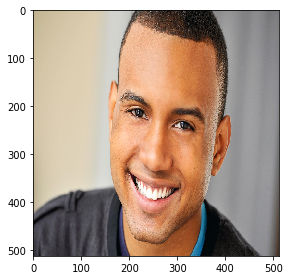

In [6]:
X = cv2.imread('./Dataset/122. mensheadshot-0020.jpg')
X = cv2.resize(X, (512, 512))
img = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
lab_image = rgb2lab(img)
X = lab_image[:, :, 0].reshape(512, 512, 1)
Y = lab_image[:, :, 1:]
print(np.shape(X), np.shape(Y))

imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


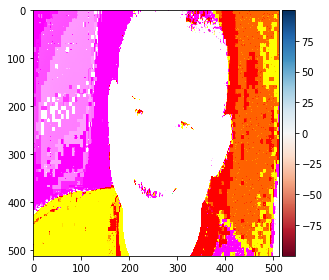

In [7]:
imshow(lab_image)

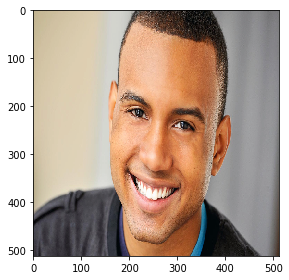

In [8]:
res = np.zeros((512, 512, 3))
res[:, :, 0] = X[:, :, 0]
res[:, :, 1] = Y[:, :, 0]
res[:, :, 2] = Y[:, :, 1]
res = lab2rgb(res)
imshow(res)

99.80363997839936|0.6459162915570928|52.20145914984175|-15.259683040756967
0.9980363997839936|0.006459162915570928|0.4078238996081387|-0.1192162737559138


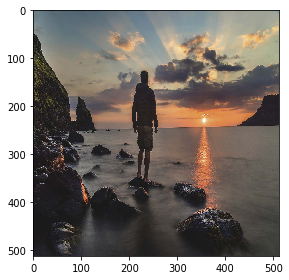

In [9]:
img_list = os.listdir('./Dataset/')
batch_X = []
batch_Y = []
for i in range(1):
    X = cv2.imread('./Dataset/' + img_list[i])
    X = cv2.resize(X, (512, 512))
    img = cv2.cvtColor(X, cv2.COLOR_BGR2RGB)
    lab_image = rgb2lab(img)
    X = lab_image[:, :, 0].reshape(512, 512, 1)
    Y = lab_image[:, :, 1:]
    batch_X.append(X)
    batch_Y.append(Y)
    
print(np.max(batch_X), np.min(batch_X), np.max(batch_Y), np.min(batch_Y), sep='|')
batch_X = np.asarray(np.asarray(batch_X) / 100.0)
batch_Y = np.asarray(batch_Y) / 128.0
print(np.max(batch_X), np.min(batch_X), np.max(batch_Y), np.min(batch_Y), sep='|')
imshow(img)

In [10]:
if True:

    loss = []
    with graph.as_default():

        inp_img = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 1])
        out_img = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 2])
        sess = tf.Session(graph=graph)

        batch_image, batch_label = batch_X, batch_Y
        pred = COLOR(inp_img)
        cost = tf.losses.mean_squared_error(pred, out_img)
        optimizer = tf.train.AdamOptimizer(0.00001).minimize(cost)
        sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

        for i in tqdm(range(10000)):

            _, j, summary = sess.run([optimizer, cost, merged], 
                                     feed_dict={inp_img: batch_image, out_img: batch_label})
            loss.append(j)
            

100%|██████████| 10000/10000 [05:46<00:00, 28.90it/s]


In [11]:
print('Maximum loss: {}\tMaximum loss at #epoch: {}\nMinimum loss: {}\tMinimum loss at #iteration: {}'
     .format(np.max(loss), np.argmax(loss), np.min(loss), np.argmin(loss)))

Maximum loss: 0.8167201280593872	Maximum loss at #epoch: 0
Minimum loss: 0.0016473501455038786	Minimum loss at #iteration: 9989


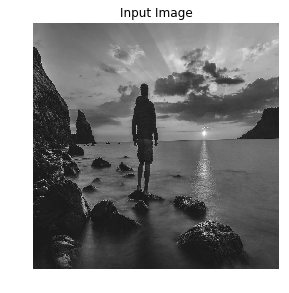

In [12]:
grey = rgb2gray(img)
imshow(grey)
plt.axis('off')
plt.title('Input Image')
plt.savefig('./images/alpha/input.png', bbox_inches='tight')
plt.show()

(1, 512, 512, 2)
Maximum and minimum values of input:  99.80363997839936 0.6459162915570928
Maximum and minimum values of output:  40.201756 -19.577032
(512, 512, 1) (512, 512, 2)
(512, 512) (512, 512) (512, 512)


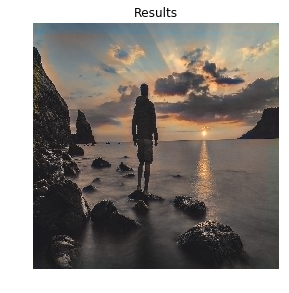

In [13]:
output = COLOR(batch_X)
print(output.shape)
output = sess.run(output)
output = output * 128.0
print('Maximum and minimum values of input: ', np.max(X), np.min(X))
print('Maximum and minimum values of output: ', np.max(output), np.min(output))


out = np.zeros((512, 512, 3))
indx = 0
Y = output[indx]
print(X.shape, Y.shape)
print(X[:, :, 0].shape, Y[:, :, 0].shape, Y[:, :, 1].shape)


out[:, :, 0] = X[:, :, 0]
out[:, :, 1] = Y[:, :, 0]
out[:, :, 2] = Y[:, :, 1]
out = lab2rgb(out)
imshow(out)
plt.axis('off')
plt.title('Results')
plt.savefig('./images/alpha/results.png', bbox_inches='tight')
plt.show()

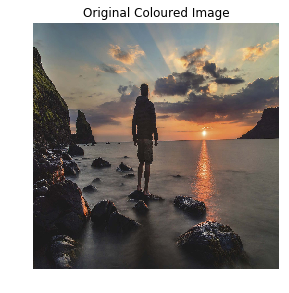

In [14]:
imshow(img)
plt.axis('off')
plt.title('Original Coloured Image')
plt.savefig('./images/alpha/original.png', bbox_inches='tight')
plt.show()